In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from tqdm import tqdm_notebook

# Prepare reference data

In [26]:
!rm data.csv
!wget https://open-covid-19.github.io/data/data.csv

--2020-04-18 19:32:18--  https://open-covid-19.github.io/data/data.csv
Resolving open-covid-19.github.io (open-covid-19.github.io)... 185.199.109.153, 185.199.110.153, 185.199.111.153, ...
Connecting to open-covid-19.github.io (open-covid-19.github.io)|185.199.109.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2582167 (2.5M) [text/csv]
Saving to: ‘data.csv’

data.csv            100%[===================>]   2.46M  1.15MB/s    in 2.2s    

2020-04-18 19:32:21 (1.15 MB/s) - ‘data.csv’ saved [2582167/2582167]



In [27]:
df_reference = pd.read_csv("data.csv")

f = df_reference["CountryCode"] == "CH"
f &= df_reference["RegionCode"].isna()
df_reference.loc[f, "scenario"] = "switzerland"

f = df_reference["CountryCode"] == "FR"
f &= df_reference["RegionCode"] == "IDF"
df_reference.loc[f, "scenario"] = "ile_de_france"

f = df_reference["CountryCode"] == "BR"
f &= df_reference["RegionCode"] == "SP"
df_reference.loc[f, "scenario"] = "sao_paulo"

f = df_reference["CountryCode"] == "US"
f &= df_reference["RegionCode"] == "CA"
df_reference.loc[f, "scenario"] = "san_francisco"

df_reference = df_reference[~df_reference["scenario"].isna()]
df_reference = df_reference.sort_values(by = "Date")

df_reference = df_reference[df_reference["Confirmed"] > 100]
df_reference.to_csv("reference.csv")

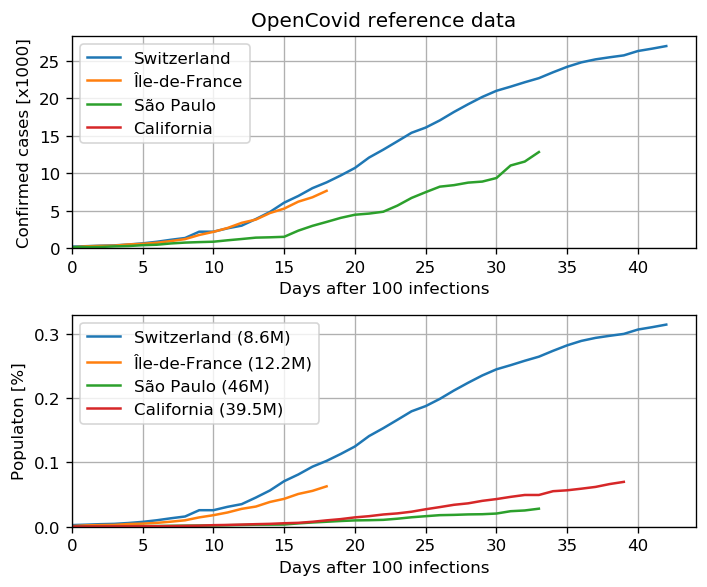

In [28]:
df_reference = pd.read_csv("reference.csv")

plt.figure(dpi = 120, figsize = (6, 5))

plt.subplot(2, 1, 1)

f = df_reference["scenario"] == "switzerland"
plt.plot(df_reference[f]["Confirmed"].values * 1e-3, label = "Switzerland")

f = df_reference["scenario"] == "ile_de_france"
plt.plot(df_reference[f]["Confirmed"].values * 1e-3, label = "Île-de-France")

f = df_reference["scenario"] == "sao_paulo"
plt.plot(df_reference[f]["Confirmed"].values * 1e-3, label = "São Paulo")

f = df_reference["scenario"] == "california"
plt.plot(df_reference[f]["Confirmed"].values * 1e-3, label = "California")

plt.xlabel("Days after 100 infections")
plt.ylabel("Confirmed cases [x1000]")

plt.legend(loc = "best")
plt.grid()

plt.ylim([0, None])
plt.xlim([0, None])

plt.title("OpenCovid reference data")

plt.subplot(2, 1, 2)

f = df_reference["scenario"] == "switzerland"
plt.plot(100 * df_reference[f]["Confirmed"].values / 8591365, label = "Switzerland (8.6M)")

f = df_reference["scenario"] == "ile_de_france"
plt.plot(100 * df_reference[f]["Confirmed"].values / 12213364, label = "Île-de-France (12.2M)")

f = df_reference["scenario"] == "sao_paulo"
plt.plot(100 * df_reference[f]["Confirmed"].values / 45919049, label = "São Paulo (46M)")

f = df_reference["scenario"] == "san_francisco"
plt.plot(100 * df_reference[f]["Confirmed"].values / 39512223, label = "California (39.5M)")

plt.xlabel("Days after 100 infections")
plt.ylabel("Populaton [%]")

plt.grid()
plt.legend(loc = "best")

plt.ylim([0, None])
plt.xlim([0, None])

plt.tight_layout()
plt.savefig("images/reference.png")

# Calibration

In [29]:
sample_rate = "25pct"
scenarios = ["switzerland", "ile_de_france", "sao_paulo", "san_francisco"]
calibration_parameters = ["0.0000020", "0.0000025", "0.0000030"]

scenario_labels = {
    "switzerland": "Switzerland",
    "ile_de_france": "Île-de-France",
    "sao_paulo": "São Paulo",
    "san_francisco": "San Francisco"
}

In [30]:
df_calibration = []

with tqdm_notebook(total = len(scenarios) * len(calibration_parameters)) as progress:
    for scenario in scenarios:
        for calibration_parameter in calibration_parameters:
            !scp -C euler:/cluster/work/ivt_vpl/covid/run/{scenario}_{sample_rate}_{calibration_parameter}_output/infections.txt infections.txt
            
            df = pd.read_csv("infections.txt", sep = "\t")
            
            df["scenario"] = scenario
            df["sample_rate"] = sample_rate
            df["calibration_parameter"] = float(calibration_parameter)

            df_calibration.append(df)
            progress.update()
            
df_calibration = pd.concat(df_calibration)
df_calibration.to_csv("calibration.csv")

Autoloading openblas/0.2.13_seq and sqlite/3.15.0
infections.txt                                100%   15KB 246.9KB/s   00:00    
Autoloading openblas/0.2.13_seq and sqlite/3.15.0
infections.txt                                100%   12KB 200.4KB/s   00:00    
Autoloading openblas/0.2.13_seq and sqlite/3.15.0
infections.txt                                100%   12KB 188.5KB/s   00:00    
Autoloading openblas/0.2.13_seq and sqlite/3.15.0
infections.txt                                100%   14KB 237.1KB/s   00:00    
Autoloading openblas/0.2.13_seq and sqlite/3.15.0
infections.txt                                100%   14KB  81.7KB/s   00:00    
Autoloading openblas/0.2.13_seq and sqlite/3.15.0
infections.txt                                100%   12KB  97.6KB/s   00:00    
Autoloading openblas/0.2.13_seq and sqlite/3.15.0
infections.txt                                100% 2146    36.2KB/s   00:00    
Autoloading openblas/0.2.13_seq and sqlite/3.15.0
infections.txt                          

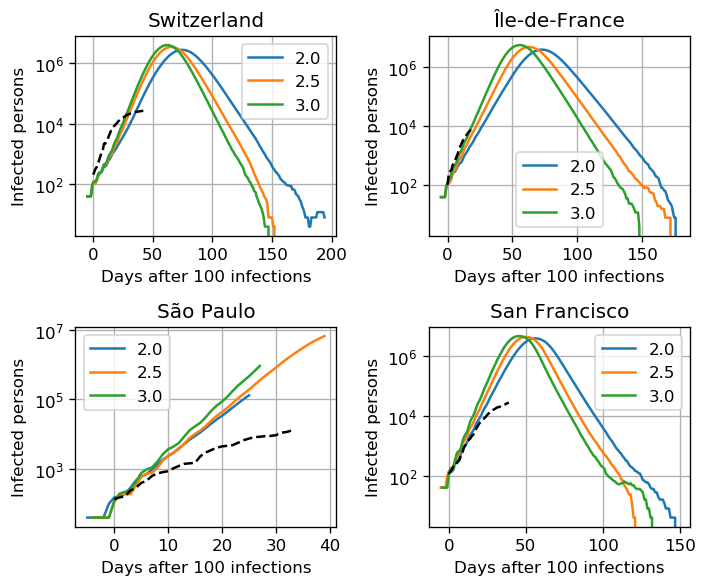

In [31]:
df_calibration = pd.read_csv("calibration.csv")

rows = np.ceil(len(scenarios) / 2)
plt.figure(dpi = 120, figsize = (6.0, 2.5 * rows))

for scenario_index, scenario in enumerate(scenarios):
    plt.subplot(rows, 2, scenario_index + 1)
    plt.title(scenario_labels[scenario])
    
    df_scenario = df_calibration[df_calibration["scenario"] == scenario]
    df_scenario_reference = df_reference[df_reference["scenario"] == scenario]
    
    for calibration_parameter in calibration_parameters:
        calibration_parameter = float(calibration_parameter)
        df_run = df_scenario[df_scenario["calibration_parameter"] == calibration_parameter]
        
        offset = np.count_nonzero(df_run.iloc[:50]["nTotalInfected"] <= 100)
        
        plt.semilogy(
            np.arange(len(df_run)) - offset,
            df_run["nTotalInfected"].values, 
            label = calibration_parameter * 1e6
        )
        
    reference_values = df_scenario_reference["Confirmed"].values
    plt.semilogy(reference_values, "k--")
        
    plt.legend(loc = "best")
    plt.grid()
    
    plt.xlabel("Days after 100 infections")
    plt.ylabel("Infected persons")
    
plt.tight_layout()
plt.savefig("images/calibration.png")